In [20]:
import sys
import nltk
import numpy as np
import pandas as pd
from copy import deepcopy
import gensim
from gensim.models import Word2Vec
from gensim.models import Phrases
import re
from nltk.corpus import stopwords
from scipy.special import expit as sigmoid 
import os

import re
import fitz  


In [21]:
codes = [18, 19, 28, 29]


def splitIntoSets(code):
    
    csv_path = f"{code}_17 to 39.csv"

    df = pd.read_csv(csv_path)

    total_rows = len(df)
    testingSetSize = round(0.1 * total_rows)
    remainingSize = total_rows - testingSetSize


    testingSet = df.iloc[:testingSetSize]['Bill Id'].tolist()


    remaining_df = df.iloc[testingSetSize:].sample(frac=1, random_state=42) 
    
    validationSet = remaining_df.iloc[:testingSetSize]['Bill Id'].tolist()


    trainingSet = remaining_df.iloc[testingSetSize:]['Bill Id'].tolist()
    
    return trainingSet, testingSet, validationSet





In [26]:
import fitz  
import re

def extract_clean_flat_text(pdf_path):
    try:
        doc = fitz.open(pdf_path)

        if doc.page_count > 2:
            pages = [doc[i].get_text() for i in range(1, doc.page_count - 1)]
        else:
            pages = []
        
        doc.close()  

        full_text = " ".join(pages)
        full_text = full_text.replace("\n", " ").strip()
        full_text = re.sub(r"\([^)]*\)", "", full_text)  
        full_text = re.sub(r"\b\d+\b", "", full_text)  
        full_text = re.sub(r"[^a-zA-Z.,; ]", " ", full_text)  
        full_text = re.sub(r"\s+", " ", full_text)  
        return full_text.lower().strip()

    except fitz.EmptyFileError:
        print(f"Warning: The file {pdf_path} is empty and cannot be processed.")
    except Exception as e:
        print(f"Error processing file {pdf_path}: {e}")

    return ""  

In [53]:

codes = [18, 19, 28, 29]

import os
import re

def count_sentences(text):
    """ Utility function to count sentences in a given text. """
    return len(re.split(r'(?<=[.!?]) +', text))

def makeDataSets(codes):
    total_sentences = 0
    sentence_counts = {'training': 0, 'testing': 0, 'validation': 0}
    
    for code in codes:
        inBasePath = r"C:\Users\ander\Downloads\MLP\billTextDownload"
        inPath = os.path.join(inBasePath, f"{code}_17 to 39")
        
        outputBase = r"C:\Users\ander\Downloads\MLP\cleanedTextFull"
        outputPath = os.path.join(outputBase, f"{code}")
        os.makedirs(outputPath, exist_ok=True)
        
        trainingIndexes, testingIndexes, validationIndexes = splitIntoSets(code)
        
 
        training_text_path = os.path.join(outputPath, "Training", f"training_text{code}.txt")
        os.makedirs(os.path.join(outputPath, "Training"), exist_ok=True)
        
        with open(training_text_path, 'w', encoding='utf-8') as output_file:
            for billID in trainingIndexes:
                for filename in os.listdir(inPath):
                    if filename.endswith(".pdf"):
                        bill_number = filename[:-4].split('_')[-1]
                        try:
                            bill_number = int(bill_number)
                        except ValueError:
                            continue
                        if bill_number == billID:
                            pdf_path = os.path.join(inPath, filename)
                            extracted_text = extract_clean_flat_text(pdf_path)
                            if extracted_text:
                                sentence_count = count_sentences(extracted_text)
                                sentence_counts['training'] += sentence_count
                                total_sentences += sentence_count
                                output_file.write(extracted_text + '\n')

                                
        validation_text_path = os.path.join(outputPath, "Validation", f"validation_text{code}.txt")
        os.makedirs(os.path.join(outputPath, "Validation"), exist_ok=True)
        
        with open(validation_text_path, 'w', encoding='utf-8') as output_file:
            for billID in validationIndexes:
                for filename in os.listdir(inPath):
                    if filename.endswith(".pdf"):
                        bill_number = filename[:-4].split('_')[-1]
                        try:
                            bill_number = int(bill_number)
                        except ValueError:
                            continue
                        if bill_number == billID:
                            pdf_path = os.path.join(inPath, filename)
                            extracted_text = extract_clean_flat_text(pdf_path)
                            if extracted_text:
                                sentence_count = count_sentences(extracted_text)
                                sentence_counts['validation'] += sentence_count
                                total_sentences += sentence_count
                                output_file.write(f"{bill_number}: {extracted_text}\n")
   

        testing_text_path = os.path.join(outputPath, "Testing", f"testing_text{code}.txt")
        os.makedirs(os.path.join(outputPath, "Testing"), exist_ok=True)
        
        with open(testing_text_path, 'w', encoding='utf-8') as output_file:
            for billID in testingIndexes:
                for filename in os.listdir(inPath):
                    if filename.endswith(".pdf"):
                        bill_number = filename[:-4].split('_')[-1]
                        try:
                            bill_number = int(bill_number)
                        except ValueError:
                            continue
                        if bill_number == billID:
                            pdf_path = os.path.join(inPath, filename)
                            extracted_text = extract_clean_flat_text(pdf_path)
                            if extracted_text:
                                sentence_count = count_sentences(extracted_text)
                                sentence_counts['testing'] += sentence_count
                                total_sentences += sentence_count
                                output_file.write(f"{bill_number}: {extracted_text}\n")


    print("Total sentences across all datasets:", total_sentences)
    print("Sentences in Training data:", sentence_counts['training'])
    print("Sentences in Testing data:", sentence_counts['testing'])
    print("Sentences in Validation data:", sentence_counts['validation'])



In [54]:
makeDataSets(codes)

Total sentences across all datasets: 329300
Sentences in Training data: 244006
Sentences in Testing data: 39003
Sentences in Validation data: 46291


In [55]:

# 1 Fail
# 2 Success
# 8 Commons
# 9 Lords
#18 failed commons


nltk.download('stopwords')




def splitSentences(text):
    
    sentences = re.split(r'\.\s+', text)
    stop_words = set(stopwords.words('english'))
    
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    filtered_sentences = []
    for sentence in sentences:
        words = sentence.split()
        filtered_words = [word for word in words if word.lower() not in stop_words]
        filtered_sentences.append(filtered_words)
        
    return filtered_sentences

def splitDocument(house_and_status = [18,19,28,29]):
    for code in house_and_status: 
        file_name = f"cleanedTextFull/{code}/Training/training_text{code}.txt"
        try:
            with open(file_name, 'r', encoding="utf-8") as file:
                for line in file:
                    yield splitSentences(line)
            print(f"Read File{file_name}")
        except UnicodeDecodeError as e:
            print(f"Unicode decode error")
# returns a list of lists . List each sentnece, and inside there is a list of words for each sentence


def splitDocumentALL(startSession, endSession, house_and_status = [18,19,28,29]):
    for code in house_and_status: 
        file_name = f"cleanedTextFull/{code}_{startSession} to {endSession} fullText.txt"
        try:
            with open(file_name, 'r', encoding="utf-8") as file:
                for line in file:
                    yield splitSentences(line)
            print(f"Read File{file_name}")
        except UnicodeDecodeError as e:
            print(f"Unicode decode error")


    



# input (sentence: list of words, model: gensim model, window: window= windowSize of word2vec, 
#debug: print intermediate calculations for debugging)

def score_sentence(sentence, model, window=7, debug=False):
    log_prob = 0.0 # total log prob for the sentence
    sentence_length = len(sentence)
    word_pair_probs = []  

    # Code for equation 1 
    for index, center_word in enumerate(sentence):
        if center_word not in model.wv:
            if debug:
                print(f"Center word '{center_word}' not in vocabulary.")
            continue
        center_vector = model.wv[center_word]

        start = max(0, index - window)
        end = min(sentence_length, index + window + 1)

        for j in range(start, end):
            if j == index:
                continue
            context_word = sentence[j]
            if context_word not in model.wv:
                if debug:
                    print(f"Context word '{context_word}' not in vocabulary.")
                continue
            context_vector = model.wv[context_word]

            dot_product = np.dot(center_vector, context_vector)
            prob = sigmoid(dot_product)

            word_pair_probs.append((center_word, context_word, prob))

            log_prob += np.log(prob + 1e-10)

    if debug:
        print("\n--- Word Pair Probabilities ---")
        for center, context, prob in word_pair_probs:
            print(f"p({context} | {center}) = {prob:.6f}")

    return log_prob




# Score an entire document (S sentences) under all models (Equation 2)
# input (sentencces:  a list of sentences ,models: the dictionary of models, window: the window size for score sentences)
# outpur: a sentences x categories (failed , succesful ....) with eahc sentence score according to score_sentence

def score_document(sentences, models, window=5):
    """
    Compute the score x category matrix of sentence scores for a document.
    
    sentences: list of sentences, each sentence is a list of words
    models: dict of {category: Word2Vec model}
    """
    S = len(sentences)
    C = len(models)
    
    sentence_scores = np.zeros((S, C))
    
    for s_idx, sentence in enumerate(sentences):
        for c_idx, (category, model) in enumerate(models.items()):
            sentence_scores[s_idx, c_idx] = score_sentence(sentence, model, window)
    
    return sentence_scores



# calculate document probabilities (Equation 5)

# input: the sxc array
# output: a 1x cateories array with the average score for all sentences in document 
def document_probabilities(sentence_scores):

    return sentence_scores.mean(axis=0)



# compute class probabilities ( Equation 3)

# input:  the array from document_probabilities
#ouput: normalized probabilities after bayes rule is applied #todo: change the priors to correspond to each class 
def class_probabilities(doc_probs):
    """
    Compute class probabilities using Bayes rule.
    Assuming uniform priors.
    """
    priors = np.ones(len(doc_probs)) / len(doc_probs)
    # bayes rule
    probs = (doc_probs * priors) / np.sum(doc_probs * priors)
    return probs



# classify the document (Equation 6)
# checks which of the numbers in the 1d array from document probabilities (the average across the classes ) is biggest and returns the index and array (for debuging) 
 
def classify_document(sentence_scores):
    doc_probs = document_probabilities(sentence_scores)
    predicted_class_idx = np.argmax(doc_probs)
    return predicted_class_idx, doc_probs



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ander\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [74]:
startSession = 17
endSession= 39



#combine sentences from all 4 files into 1 list of lists. Each sentence a list of words 
allSentences = [sentence for listOfSentneces in splitDocumentALL(startSession, endSession) for sentence in listOfSentneces]

print("Sentences retreived")
print(len(allSentences))

houseDictionary = {'FailedCommons': [18], 'FailedLords': [19], "SuccesCommons": [28], "SuccessLords":[29]}
[g for g in houseDictionary]



# populate a dictionary: key: category of bill, value: list of lists with sentences from bills of that category(FailedCommons, etc)
categorizedBillSentences = {key: [sentence for listOfSentneces in splitDocument(houseDictionary[key]) for sentence in listOfSentneces] for key in houseDictionary}

# creates series with how many sentnces for each catgory(debugging)
numberBills = pd.Series({key: len(categorizedBillSentences[key]) for key in houseDictionary}, dtype="float64" )

print("Sentences per category")
print(f"Sentences in FailedCommons {numberBills[0]}")
print(f"Sentences in FailedCommons {numberBills[1]}")
print(f"Sentences in FailedCommons {numberBills[2]}")
print(f"Sentences in FailedCommons {numberBills[3]}")


# populate houseDictionary with bills of appropaite category as lists of lists
for key in houseDictionary:
    for i in range(len(categorizedBillSentences[key])):
        categorizedBillSentences[key][i] = [word for word in categorizedBillSentences[key][i]]


#creates a dictionary of word2vec models initialized with the vocabulary of all sentences         


models = { }


def trainW2V(key, T=20):
    sentences = categorizedBillSentences[key]
    for epoch in range(T):
        print(f"{epoch}", end="")
        np.random.shuffle(sentences)
        models[key].train(sentences, total_examples=len(sentences), epochs=1)
        models[key].alpha *= 0.9
        models[key].min_alpha = models[key].alpha
    print(".")


for key in houseDictionary:
    models[key] = Word2Vec(allSentences, workers=4, hs=1, sg=1, negative=0, min_count=10, vector_size =300,window = 7 )
    models[key].build_vocab(allSentences) 
    
    

# trains each of the initialized models only with text from each specific category. 4 models trained with different bill text
for key in houseDictionary:
    print(key, end=":")
    trainW2V(key)


print(models.keys())



Read FilecleanedTextFull/18_17 to 39 fullText.txt
Read FilecleanedTextFull/19_17 to 39 fullText.txt
Read FilecleanedTextFull/28_17 to 39 fullText.txt
Read FilecleanedTextFull/29_17 to 39 fullText.txt
Sentences retreived
259841
Read FilecleanedTextFull/18/Training/training_text18.txt
Read FilecleanedTextFull/19/Training/training_text19.txt
Read FilecleanedTextFull/28/Training/training_text28.txt
Read FilecleanedTextFull/29/Training/training_text29.txt
Sentences per category
Sentences in FailedCommons 41666.0
Sentences in FailedCommons 21913.0
Sentences in FailedCommons 157403.0
Sentences in FailedCommons 21045.0
FailedCommons:012345678910111213141516171819.
FailedLords:012345678910111213141516171819.
SuccesCommons:012345678910111213141516171819.
SuccessLords:012345678910111213141516171819.
dict_keys(['FailedCommons', 'FailedLords', 'SuccesCommons', 'SuccessLords'])


In [75]:
for key, model in models.items():
    num_words = len(model.wv.key_to_index)
    print(f"{key} has learned {num_words} words")

FailedCommons has learned 12578 words
FailedLords has learned 12578 words
SuccesCommons has learned 12578 words
SuccessLords has learned 12578 words


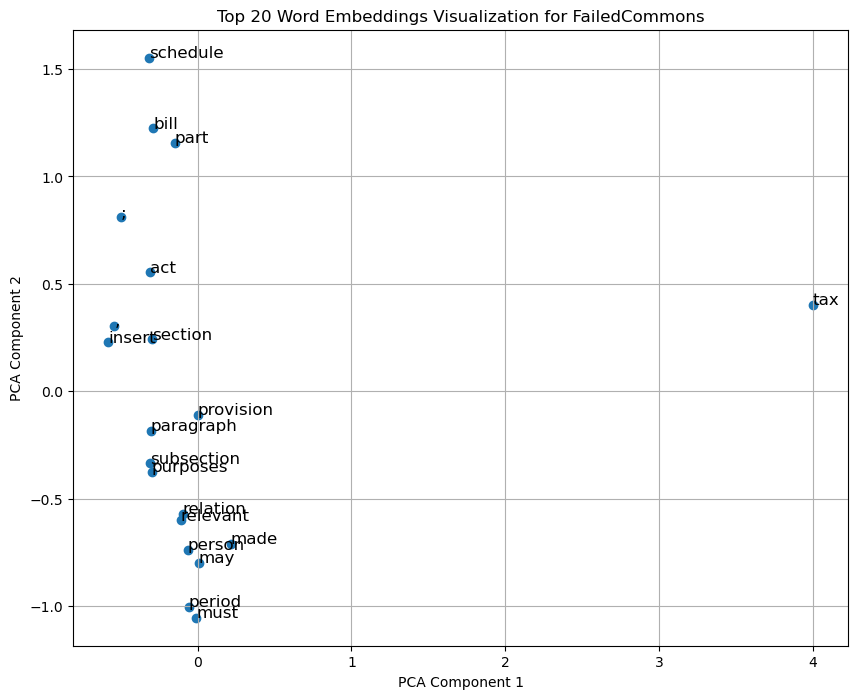

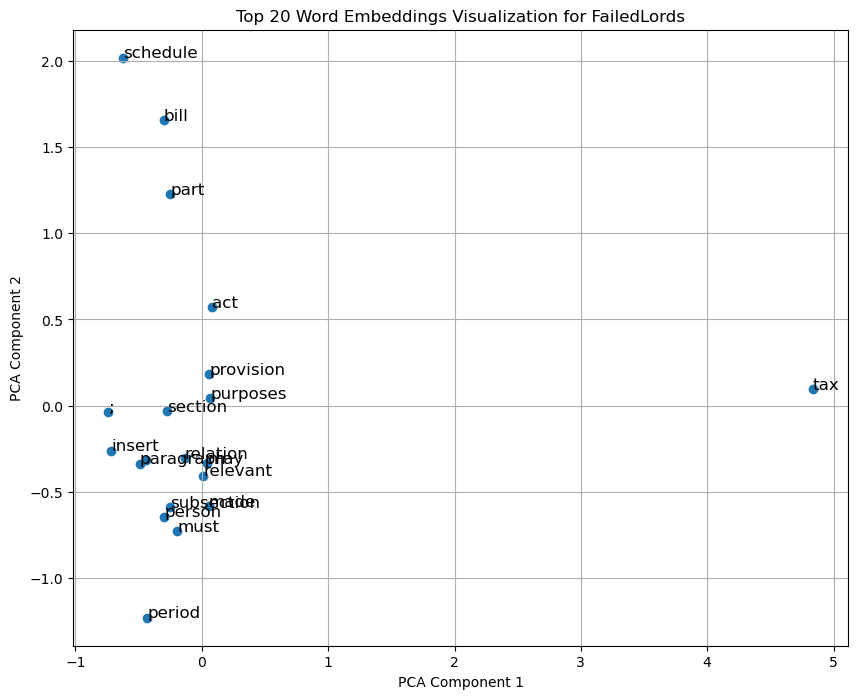

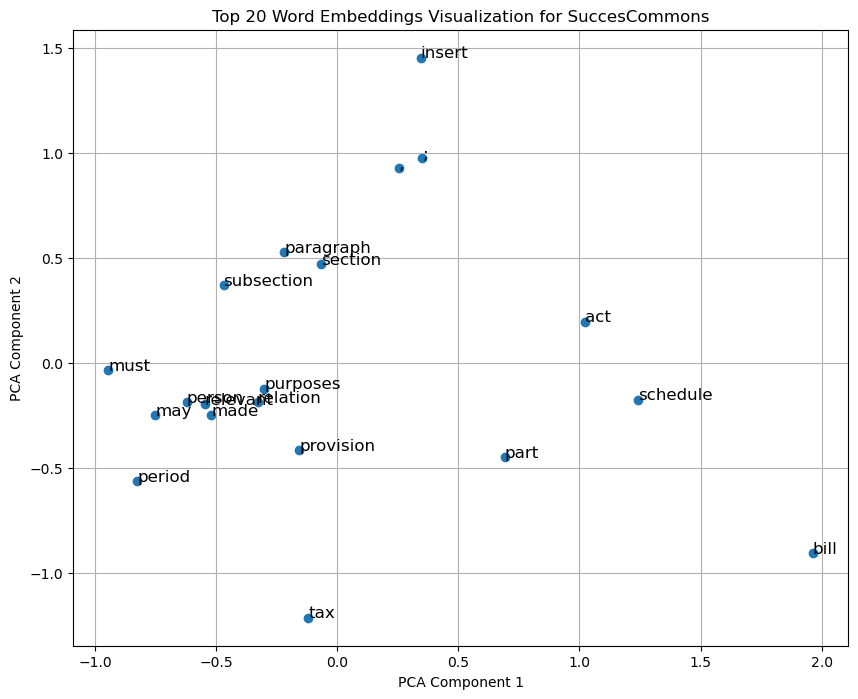

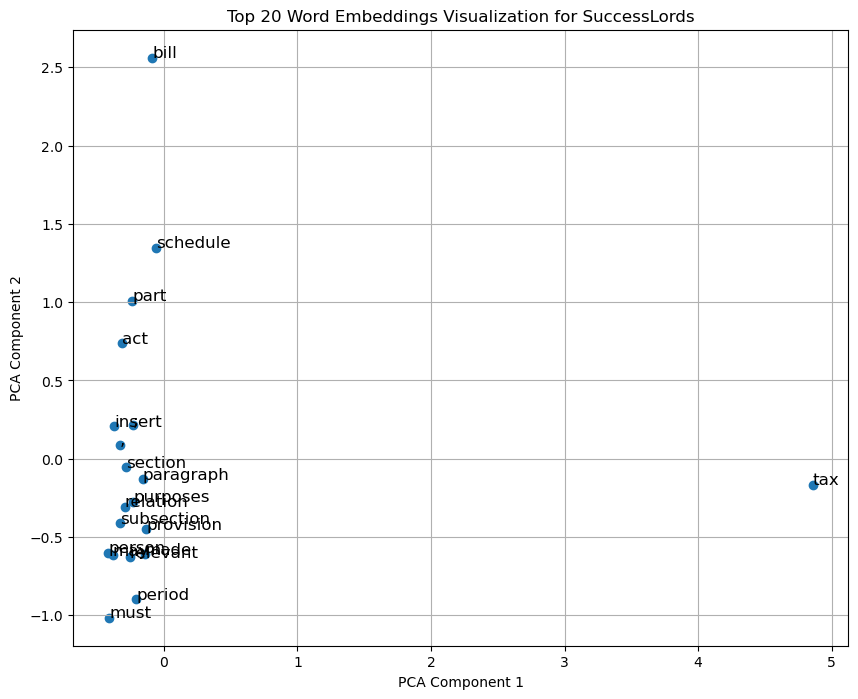

In [76]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualizeModel(model, key, top_n=20):
  
    if not hasattr(model, 'wv') or not hasattr(model.wv, 'index_to_key'):
        raise ValueError("Wrong model .")
    

    top_words = model.wv.index_to_key[:top_n] 
    top_word_vectors = model.wv[top_words]  
    

    pca = PCA(n_components=2)
    result = pca.fit_transform(top_word_vectors)
    
  
    plt.figure(figsize=(10, 8))
    plt.scatter(result[:, 0], result[:, 1])
    

    for i, word in enumerate(top_words):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]), fontsize=12)
    
    plt.title(f"Top {top_n} Word Embeddings Visualization for {key}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()

for key , model in models.items():
    visualizeModel(model, key)



In [77]:
## Evaluate the trained models 

def scoreSentences(listOfSentences, modelsList, predictedCategory):
    success= 0
    fail =0
    
    categories = list(modelsList.keys())
    
    for i, sentence_text in enumerate(listOfSentences, 1):
        document = splitSentences(sentence_text)
        sentence_scores = score_document(document, modelsList, window=5)
        doc_probs = document_probabilities(sentence_scores)
        probs = class_probabilities(doc_probs)
        predicted_idx, doc_probs = classify_document(sentence_scores)
        
        #print(f" Predicting Sentence {document}")
        #print(f"\nSentence {i}:")
        #print(f"Predicted class: {categories[predicted_idx]}")
        #print(f"Document probabilities: {doc_probs}")
        #print(f"Class probabilities: {probs}")
        
        predicted_class = categories[predicted_idx]
        
        if (predicted_class == predictedCategory or
            (predicted_class in ["FailedCommons", "FailedLords"] and 
             predictedCategory in ["FailedCommons", "FailedLords"])):
            success += 1
        else:
            fail += 1
    total = fail + success
    
    if total > 0:
        accuracy = success / total
        print(f"Correct Prediction: {accuracy}")
    else:
        print("Error in predicition.")

def splitSentencesForTest(text):
    sentences = re.split(r'\.\s+', text)
    return [s.strip() for s in sentences if s.strip()]

def splitDocumentTest(house_and_status, max_bills=7):
    """
    Loads and yields sentences from up to `max_bills` bills in each given code's test set.
    Each bill entry must be in the format: bill_number: text
    """
    for code in house_and_status: 
        file_name = f"cleanedTextFull/{code}/Testing/testing_text{code}.txt"
        try:
            with open(file_name, 'r', encoding="utf-8") as file:
                bill_count = 0
                for line in file:
                    if bill_count >= max_bills:
                        break
                    bill_text = line.strip()
                    if ':' in bill_text:
                        # Split the line at the first colon
                        bill_text = bill_text.split(':', 1)[1].strip()

                        # Process and yield sentences
                        sentences = splitSentencesForTest(bill_text)
                        for sentence in sentences:
                            yield sentence
                        bill_count += 1  # Increment only for valid bill entries
            print(f"Read File {file_name} (used {bill_count} bills)")
        except UnicodeDecodeError as e:
            print(f"Unicode decode error in {file_name}: {e}")


            
codes= [18,19,28,19]


testDictionary = {'FailedCommons': [18], 'FailedLords': [19], "SuccesCommons": [28], "SuccessLords":[29]}

for key, codes in testDictionary.items():
    testDictionary[key] = [sentence for sentence in splitDocumentTest(house_and_status=codes)]

    
for key, code in testDictionary.items():
    testSentences = testDictionary[key]
    
    print (f" Number of sentences for {key} is {len(testSentences)}")
    print(f"The accuracy for {key} is ") 
    scoreSentences(testSentences, models, key)
    


descriptionOfModel = "workers=4, hs=1, sg=1, negative=0, min_count=10, vector_size =300,window = 7"
for key, model in models.items():
    filename = f"{key}_word2vec_{descriptionOfModel}.model"
    model.save(filename)
    print(f"Model for {key} saved as {filename}")

Read File cleanedTextFull/18/Testing/testing_text18.txt (used 7 bills)
Read File cleanedTextFull/19/Testing/testing_text19.txt (used 7 bills)
Read File cleanedTextFull/28/Testing/testing_text28.txt (used 7 bills)
Read File cleanedTextFull/29/Testing/testing_text29.txt (used 7 bills)
 Number of sentences for FailedCommons is 268
The accuracy for FailedCommons is 


C:\Users\ander\miniconda3\envs\pdiot\lib\site-packages\ipykernel_launcher.py:147: RuntimeWarning: invalid value encountered in true_divide


Correct Prediction: 0.5074626865671642
 Number of sentences for FailedLords is 447
The accuracy for FailedLords is 
Correct Prediction: 0.4451901565995526
 Number of sentences for SuccesCommons is 933
The accuracy for SuccesCommons is 
Correct Prediction: 0.7942122186495176
 Number of sentences for SuccessLords is 179
The accuracy for SuccessLords is 
Correct Prediction: 0.5754189944134078
Model for FailedCommons saved as FailedCommons_word2vec_workers=4, hs=1, sg=1, negative=0, min_count=10, vector_size =300,window = 7.model
Model for FailedLords saved as FailedLords_word2vec_workers=4, hs=1, sg=1, negative=0, min_count=10, vector_size =300,window = 7.model
Model for SuccesCommons saved as SuccesCommons_word2vec_workers=4, hs=1, sg=1, negative=0, min_count=10, vector_size =300,window = 7.model
Model for SuccessLords saved as SuccessLords_word2vec_workers=4, hs=1, sg=1, negative=0, min_count=10, vector_size =300,window = 7.model


In [ ]:
#Scoring the sentences with a CNN 

def vectorize(sentence, codes = [18,19,28,29]):
    words = sentence.split()
    words_vecs = [models[code].wv[word] for word in words if word in models[code].wv]
    if len(words_vecs) = 0:
        return np.zeros(300)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)
    
codes = [18,19,28,29]

categorizedBillSentences = {key: [sentence for listOfSentneces in splitDocument(houseDictionary[key]) for sentence in listOfSentneces] for key in houseDictionary}
houseDictionary = {'FailedCommons': [18], 'FailedLords': [19], "SuccesCommons": [28], "SuccessLords":[29]}
[g for g in houseDictionary]

code_to_key = {v[0]: k for k, v in houseDictionary.items()}

x_train_arrays = {}

for code in codes:
    key = code_to_ket
    